In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from network import Net #Upload the network.py to the directory if you want this to work or just open the 3rd cell.

if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # I used this command to easily move between GPU and CPU
print(device)

BATCH_SIZE = 16 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 25 # Number of times we will go through all the training images. Do not go over 25

#I tested it over 25 epochs as well just to be sure its consistent. It reaches above 90% before 25 epochs.

LEARNING_RATE = 1e-3 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 0.0001 # Regularization factor to reduce overfitting

cuda:0


In [ ]:
#New CNN. I loaded it here in order to modify the network easily. You can skip this line since it calls from the .py
"""
class Net(nn.Module):

    def __init__(self, n_classes=10):
        super().__init__()
        
        # Cheatsheet:
        # Convolutions (Conv2d) need to match the input's number of channels, and can change the number of output channels
        # It's recommended that you stick to 3x3 convolutions with padding=1, which keeps the spatial size of the tensors unchanged
        # Batch normalization (BatchNorm2d) should match the input's number of channels, and do not affect the size
        # BatchNorm2d is used right after Conv2d
        # ReLU activation can be applied to tensors of any size and does not affect its shape
        # Max pooling (MaxPool2d) divides the spatial dimensions of the image. 
        # Stick to MaxPool2d(2, 2) in this exercise, which divides the size of the output by 2 in each axis.

        # Note: Tensors (arrays) here are of shape [B, C, M, N], where:
        # B is the number of samples in a batch
        # C is the number of "color" or feature channels
        # M is the first spatial dimension
        # N is the second spatial dimension

        # Tip: try to keep track of the shape that the tensor will have after each operation. This is necessary for properly 
        # connecting the convolutional layers to the fully connected layers.

        # Input is [B, 3, 64, 64]
        self.convolutions = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1), #[B, 32, 64, 64]
            nn.ReLU(),  #[B, 32, 64, 64]
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),  #[B, 64, 64, 64]
            nn.ReLU(),  #[B, 64, 64, 64]
            nn.MaxPool2d(2,2),  #[B, 64, 32, 32]
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1), #[B, 128, 32, 32]
            nn.ReLU(), #[B, 64, 32, 32]
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1), #[B, 128, 32, 32]
            nn.ReLU(), #[B, 128, 32, 32]
            nn.MaxPool2d(2,2), #[B, 128, 16, 16]
            nn.Dropout(0.2), #To Prevent Overfitting

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1), #[B, 128256, 16, 16]
            nn.ReLU(), #[B, 256, 16, 16]
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1), #[B, 256, 16, 16]
            nn.ReLU(), #[B, 256, 16, 16]
            nn.MaxPool2d(2,2), #[B, 256, 8, 8]
            nn.Dropout(0.15) #To Prevent Overfitting
        )

        # Input will be reshaped from [B, 256, 8, 8] to [B, 256*8*8] for fully connected layers
        self.fully_connected = nn.Sequential(
            nn.Linear(256*8*8, 16), # [B, 16]
            nn.ReLU(inplace=True), # [B, 16]
            nn.Linear(16, n_classes), # [B, n_classes]
        )

        # Note: the final output must have shape [B, n_classes]

        # We're skipping a softmax activation here since we'll be using a loss function that does it automatically



    def forward(self, img):

        # Apply convolution operations
        x = self.convolutions(img)

        # Reshape
        x = x.view(x.size(0), -1)

        # Apply fully connected operations
        x = self.fully_connected(x)

        return x
"""

In [ ]:
model = Net()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=WEIGHT_DECAY)

In [ ]:
transformss = transforms.Compose([
        transforms.RandomHorizontalFlip(), #Basic augmentation to prevent overfitting.
        transforms.ToTensor()])
train_data = datasets.EuroSAT('data', download=True, transform=transformss)
train, test = random_split(train_data,[21600,5400]) #80-20 Train-Test Split
train_loader = DataLoader(train, batch_size=BATCH_SIZE)
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting data/eurosat/EuroSAT.zip to data/eurosat


In [ ]:
num_epochs = NUM_EPOCHS
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(1,num_epochs+1): # If I have spare time I will convert this into a function, but I doubt it.
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    total_correct = 0
    total_loss = 0
    total_images = 0
    total_val_loss = 0
    model.train().to(device)
    for i, (data, target) in tqdm(enumerate(train_loader)):

        images = data.to(device)
        labels = target.to(device)

        # Forward propagation
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))  
        optimizer.zero_grad()

        # Backward prop
        loss.backward()

        # Updating gradients
        optimizer.step()

        # Total number of labels
        total_images+= labels.size(0)

        # Obtaining predictions from max value
        _, predicted = torch.max(outputs.detach(), 1)

        # Calculate the number of correct answers
        correct = (predicted == labels).sum().item()

        total_correct+=correct
        total_loss+=loss.item()

    train_loss_per_epoch = total_loss / total_images
    train_acc_per_epoch =  (total_correct / total_images) * 100   

    train_loss.append(train_loss_per_epoch)
    train_accuracy.append(train_acc_per_epoch)

    scheduler.step()
    print('Train Loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss_per_epoch,train_acc_per_epoch))
    
    # Testing the model
    model.eval().to(device)

    with torch.no_grad():
        correct = 0
        total = 0
        total_losss =0

        for data, target in test_loader:

            images = data.to(device)
            labels = target.to(device)
            outputs = model(images).to(device)

            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            total_losss += loss.item()

        test_accuracy_per_epoch = correct / total * 100 #Test acc per epoch
        test_loss_per_epoch = total_losss / total  
        test_accuracy.append(test_accuracy_per_epoch)
        test_loss.append(test_loss_per_epoch)
        print('Test  Loss: {:.4f}, Test  Accuracy: {:.2f}%'.format(test_loss_per_epoch, test_accuracy_per_epoch))



Running epoch 1 of 40...



1350it [00:32, 42.03it/s]


Train Loss: 0.1406, Train Accuracy: 16.30%
Test  Loss: 0.1326, Test  Accuracy: 25.57%


Running epoch 2 of 40...



1350it [00:24, 55.21it/s]


Train Loss: 0.1121, Train Accuracy: 29.18%
Test  Loss: 0.1052, Test  Accuracy: 32.57%


Running epoch 3 of 40...



1350it [00:25, 53.82it/s]


Train Loss: 0.0974, Train Accuracy: 38.05%
Test  Loss: 0.1080, Test  Accuracy: 39.37%


Running epoch 4 of 40...



1350it [00:24, 54.38it/s]


Train Loss: 0.0746, Train Accuracy: 54.53%
Test  Loss: 0.0791, Test  Accuracy: 66.76%


Running epoch 5 of 40...



1350it [00:24, 55.41it/s]


Train Loss: 0.0593, Train Accuracy: 65.80%
Test  Loss: 0.0646, Test  Accuracy: 71.31%


Running epoch 6 of 40...



1350it [00:24, 55.38it/s]


Train Loss: 0.0508, Train Accuracy: 70.77%
Test  Loss: 0.0724, Test  Accuracy: 70.56%


Running epoch 7 of 40...



1350it [00:24, 55.52it/s]


Train Loss: 0.0458, Train Accuracy: 73.85%
Test  Loss: 0.0735, Test  Accuracy: 71.96%


Running epoch 8 of 40...



1350it [00:24, 54.81it/s]


Train Loss: 0.0410, Train Accuracy: 76.51%
Test  Loss: 0.0651, Test  Accuracy: 75.30%


Running epoch 9 of 40...



1350it [00:24, 55.32it/s]


Train Loss: 0.0374, Train Accuracy: 78.61%
Test  Loss: 0.0561, Test  Accuracy: 78.39%


Running epoch 10 of 40...



1350it [00:24, 55.26it/s]


Train Loss: 0.0342, Train Accuracy: 80.51%
Test  Loss: 0.0562, Test  Accuracy: 79.11%


Running epoch 11 of 40...



1350it [00:24, 55.25it/s]


Train Loss: 0.0315, Train Accuracy: 82.00%
Test  Loss: 0.0479, Test  Accuracy: 82.59%


Running epoch 12 of 40...



1350it [00:24, 54.35it/s]


Train Loss: 0.0287, Train Accuracy: 83.45%
Test  Loss: 0.0457, Test  Accuracy: 83.15%


Running epoch 13 of 40...



1350it [00:24, 55.11it/s]


Train Loss: 0.0266, Train Accuracy: 84.75%
Test  Loss: 0.0493, Test  Accuracy: 83.13%


Running epoch 14 of 40...



1350it [00:24, 55.18it/s]


Train Loss: 0.0244, Train Accuracy: 85.88%
Test  Loss: 0.0439, Test  Accuracy: 85.76%


Running epoch 15 of 40...



1350it [00:24, 55.11it/s]


Train Loss: 0.0222, Train Accuracy: 87.51%
Test  Loss: 0.0443, Test  Accuracy: 86.81%


Running epoch 16 of 40...



1350it [00:24, 54.64it/s]


Train Loss: 0.0202, Train Accuracy: 88.70%
Test  Loss: 0.0443, Test  Accuracy: 87.06%


Running epoch 17 of 40...



1350it [00:24, 55.23it/s]


Train Loss: 0.0185, Train Accuracy: 89.50%
Test  Loss: 0.0410, Test  Accuracy: 86.61%


Running epoch 18 of 40...



1350it [00:24, 55.38it/s]


Train Loss: 0.0172, Train Accuracy: 90.28%
Test  Loss: 0.0391, Test  Accuracy: 88.28%


Running epoch 19 of 40...



1350it [00:24, 55.20it/s]


Train Loss: 0.0155, Train Accuracy: 91.34%
Test  Loss: 0.0492, Test  Accuracy: 89.09%


Running epoch 20 of 40...



1350it [00:24, 55.24it/s]


Train Loss: 0.0142, Train Accuracy: 92.07%
Test  Loss: 0.0372, Test  Accuracy: 89.33%


Running epoch 21 of 40...



1350it [00:24, 54.58it/s]


Train Loss: 0.0129, Train Accuracy: 92.88%
Test  Loss: 0.0232, Test  Accuracy: 90.65%


Running epoch 22 of 40...



1350it [00:24, 55.38it/s]


Train Loss: 0.0122, Train Accuracy: 93.26%
Test  Loss: 0.0302, Test  Accuracy: 90.56%


Running epoch 23 of 40...



1350it [00:24, 55.38it/s]


Train Loss: 0.0113, Train Accuracy: 93.69%
Test  Loss: 0.0252, Test  Accuracy: 90.72%


Running epoch 24 of 40...



1350it [00:24, 55.17it/s]


Train Loss: 0.0104, Train Accuracy: 94.33%
Test  Loss: 0.0216, Test  Accuracy: 92.15%


Running epoch 25 of 40...



1350it [00:24, 54.47it/s]


Train Loss: 0.0099, Train Accuracy: 94.56%
Test  Loss: 0.0227, Test  Accuracy: 90.80%


Running epoch 26 of 40...



1350it [00:24, 55.52it/s]


Train Loss: 0.0089, Train Accuracy: 94.96%
Test  Loss: 0.0120, Test  Accuracy: 92.54%


Running epoch 27 of 40...



1350it [00:24, 55.32it/s]


Train Loss: 0.0086, Train Accuracy: 95.31%
Test  Loss: 0.0418, Test  Accuracy: 91.94%


Running epoch 28 of 40...



1350it [00:24, 55.49it/s]


Train Loss: 0.0078, Train Accuracy: 95.69%
Test  Loss: 0.0063, Test  Accuracy: 92.52%


Running epoch 29 of 40...



1350it [00:24, 54.84it/s]


Train Loss: 0.0075, Train Accuracy: 95.85%
Test  Loss: 0.0311, Test  Accuracy: 92.72%


Running epoch 30 of 40...



1350it [00:24, 55.39it/s]


Train Loss: 0.0071, Train Accuracy: 95.99%
Test  Loss: 0.0321, Test  Accuracy: 92.78%


Running epoch 31 of 40...



1350it [00:24, 55.44it/s]


Train Loss: 0.0067, Train Accuracy: 96.36%
Test  Loss: 0.0088, Test  Accuracy: 92.65%


Running epoch 32 of 40...



1350it [00:24, 55.46it/s]


Train Loss: 0.0063, Train Accuracy: 96.57%
Test  Loss: 0.0128, Test  Accuracy: 93.94%


Running epoch 33 of 40...



1350it [00:24, 54.78it/s]


Train Loss: 0.0058, Train Accuracy: 96.74%
Test  Loss: 0.0040, Test  Accuracy: 93.87%


Running epoch 34 of 40...



1350it [00:24, 55.33it/s]


Train Loss: 0.0053, Train Accuracy: 97.00%
Test  Loss: 0.0051, Test  Accuracy: 93.35%


Running epoch 35 of 40...



1350it [00:24, 55.21it/s]


Train Loss: 0.0052, Train Accuracy: 97.02%
Test  Loss: 0.0022, Test  Accuracy: 93.76%


Running epoch 36 of 40...



1350it [00:24, 55.05it/s]


Train Loss: 0.0047, Train Accuracy: 97.28%
Test  Loss: 0.0019, Test  Accuracy: 93.50%


Running epoch 37 of 40...



1350it [00:24, 54.50it/s]


Train Loss: 0.0049, Train Accuracy: 97.21%
Test  Loss: 0.0369, Test  Accuracy: 94.11%


Running epoch 38 of 40...



1350it [00:24, 54.84it/s]


Train Loss: 0.0039, Train Accuracy: 97.79%
Test  Loss: 0.0080, Test  Accuracy: 94.04%


Running epoch 39 of 40...



1350it [00:24, 55.04it/s]


Train Loss: 0.0040, Train Accuracy: 97.78%
Test  Loss: 0.0002, Test  Accuracy: 94.50%


Running epoch 40 of 40...



1350it [00:24, 55.21it/s]


Train Loss: 0.0036, Train Accuracy: 97.89%
Test  Loss: 0.0302, Test  Accuracy: 94.20%


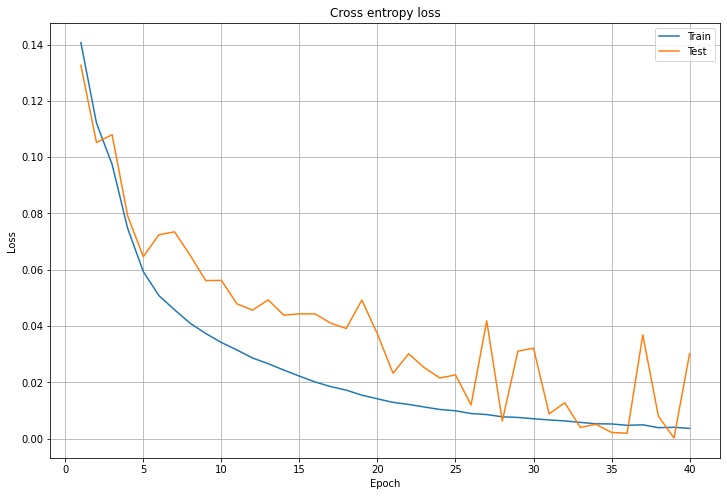

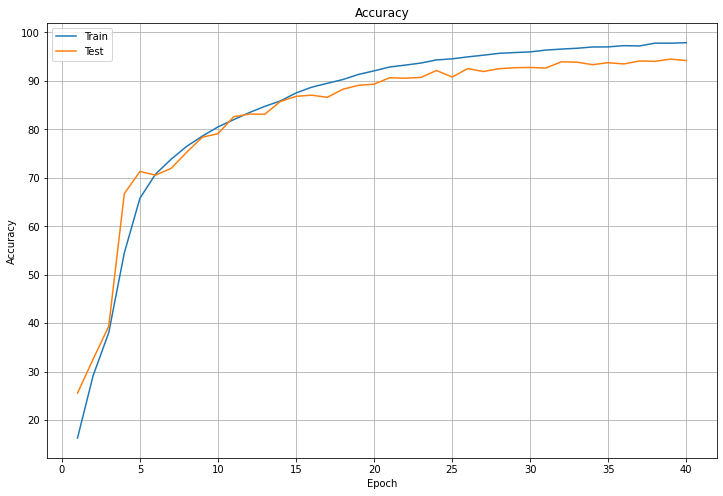

In [ ]:
epochs = np.arange(1,NUM_EPOCHS+1,1)
#Plot and save
plt.figure(figsize=(12, 8), num=1)
plt.clf()
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, test_loss, label='Test')
plt.legend()
plt.grid()
plt.title('Cross entropy loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('outputs/01-loss.pdf')

plt.figure(figsize=(12, 8), num=2)
plt.clf()
plt.plot(epochs, train_accuracy, label='Train')
plt.plot(epochs, test_accuracy, label='Test')
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('outputs/02-accuracy.pdf')

In [ ]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

Final train loss: 0.0036408420948326374
Final test loss: 0.03022461947467592
Final train accuracy: 97.88888888888889
Final test accuracy: 94.2037037037037
